<a href="https://colab.research.google.com/github/simodepth/Similarity-Tool/blob/main/Top_SERP_similarity_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SERP Similarity Tool with Serp API and Polyfuzz



---

##Description
The aim of this framework is to allow users to compare search results depending on their search query. The following script is designed to help users inform decision-making following a competitor analysis drilled on the search queries similarity.

In particular, users will be able to:
- retrieve 2 SERPs following the input of 2 different search queries
- compare URLs, snippets, highlighted words in a snippet and more
- dig down into n-gram analysis when benchmarking strings such as snippets popping from the SERPs


##Requirements and Assumptions

- Serp Api to retrieve search results page. You can sign up for free and opening an account in seconds, then you will have granted a free starting credits to play around with the API.
- It is recommended users are quite confident with the basics of Pandas as thhis framework focuses largely on manipulating information within this powerful Python library
- NLTK library will be used for tokenization purposes before whilst the Snowball stemmer will be leveraged for stemming objectives. This will take place for everything strings-related before calculating the similarity score
- **IMPORTANT** The script looks like a long deck but it's actually doubled to give users the opportunity to flex the code for each SERP. It is, in fact, recommended to take a moment to read the instructions before running every scripts to avoid any unpleasant bugs.

In [60]:
#@title Install Required Libraries
!pip install polyfuzz
!pip install google-search-results
!pip install plotly
!pip install gensim

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

#Download once if using NLTK for preprocessing
import nltk
nltk.download('punkt')

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#Libraries for clustering
from sklearn.cluster import KMeans
from polyfuzz.models import TFIDF
from polyfuzz import PolyFuzz


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Kick off the **First** SERP Audit with Google Search Api


---

What you need to do here is just a couple of tiny things.
- log in to [Serp Api](https://serpapi.com/), heading on to your account and copy and paste the API code in the `serp_apikey`
- include your search query in the payload after the `"q"`

In [47]:
from serpapi import GoogleSearch

serp_apikey = "fbb0564d15451bc375ec75f75bab1db3ae1a4775682e6c07ec8c685099506cb0" 

params = {
    "engine": "google",
    "q": "chocolate coffee",
    "location": "United Kingdom",
    "google_domain": "google.com",
    "gl": "uk",
    "hl": "en",
    "num": 10,
    "api_key": serp_apikey
}

client = GoogleSearch(params)
data = client.get_dict()

# access "organic results"
df = pd.DataFrame(data['organic_results'])
df.to_csv('results_1.csv', index=False)
df

https://serpapi.com/search


,position,title,link,displayed_link,thumbnail,date,snippet,snippet_highlighted_words,sitelinks,about_this_result,about_page_link,about_page_serpapi_link,cached_page_link,rich_snippet
0,1,Best Chocolate Coffee Recipe - IzzyCooking,https://izzycooking.com/chocolate-coffee/,https://izzycooking.com › Drinks,https://serpapi.com/searches/6341695df8f5f7b72...,17 May 2022,"How to Make Chocolate Coffee ... Add sugar, co...",[Chocolate Coffee],"{'inline': [{'title': 'Key Ingredients', 'link...",{'source': {'description': 'izzycooking.com wa...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN
1,2,Easy Instant Hot Cocoa Coffee Recipe - The Spr...,https://www.thespruceeats.com/instant-hot-coco...,https://www.thespruceeats.com › instant-hot-co...,https://serpapi.com/searches/6341695df8f5f7b72...,11 Aug 2021,Ingredients ; 1 cup milk ; 1 ounce hot cocoa m...,"[cocoa, coffee]",NaN,{'source': {'description': 'thespruceeats.com ...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN
2,3,How to Make Chocolate Coffee Recipe - Times Food,https://recipes.timesofindia.com/beverage/non-...,https://recipes.timesofindia.com › ... › Non A...,https://encrypted-tbn0.gstatic.com/images?q=tb...,16 Sept 2021,Ingredients of Chocolate Coffee · 200 gm dark ...,[Chocolate Coffee],NaN,{'source': {'description': 'recipes.timesofind...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN
3,4,Coffee Chocolate | Gifts for Coffee Lovers | H...,https://www.hotelchocolat.com/uk/shop/collecti...,https://www.hotelchocolat.com › shop › collect...,https://encrypted-tbn0.gstatic.com/images?q=tb...,NaN,Rich chocolate paired with the best coffee fla...,"[chocolate, coffee, coffee chocolate, chocolate]",NaN,{'source': {'description': 'Hotel Chocolat is ...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN
4,5,Chocolate Coffee - Amazon.co.uk,https://www.amazon.co.uk/Chocolate-Coffee/s?k=...,https://www.amazon.co.uk › Chocolate-Coffee › ...,https://encrypted-tbn0.gstatic.com/images?q=tb...,NaN,Friars Coffee Chocolate Selection Box - 24 Cho...,[Coffee Chocolate],NaN,"{'source': {'description': 'Amazon.com, Inc. i...",https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN
5,6,Mocha Coffee Recipe - Allrecipes,https://www.allrecipes.com/recipe/23538/mocha-...,https://www.allrecipes.com › Recipes › Drinks ...,https://encrypted-tbn0.gstatic.com/images?q=tb...,NaN,Ingredients · 1 cup hot brewed coffee · 1 tabl...,"[coffee, cocoa]",NaN,{'source': {'description': 'allrecipes.com was...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,NaN,NaN
6,7,Dark Chocolate Coffee Beans 400g - Grape Tree,https://www.grapetree.co.uk/dark-chocolate-cof...,https://www.grapetree.co.uk › dark-chocolate-c...,https://encrypted-tbn0.gstatic.com/images?q=tb...,NaN,Dark Chocolate Coffee Beans are delicious on t...,[Chocolate Coffee],NaN,{'source': {'description': 'grapetree.co.uk wa...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,{'top': {'detected_extensions': {'price': 4.49...


In [104]:
#@title Creating a Dataframe to View/Manipulate Data
SERP_One = pd.read_csv('/content/data.csv')
df = pd.DataFrame(SERP_One, columns=['link'])
df.columns = ['URL1']
df

,URL1
0,https://www.whittard.co.uk/coffee/discover-cof...
1,https://www.amazon.co.uk/Flavored-Coffee/s?k=F...
2,https://beaniesflavourco.co.uk/shop/flavour/in...
3,https://www.theloveofcoffee.co.uk/flavoured-co...
4,https://www.smithscoffee.co.uk/product-categor...
5,https://www.pactcoffee.com/farms/coffee-flavou...
6,https://www.coffee-direct.co.uk/collections/fl...
7,https://www.diffordsguide.com/g/1113/coffee


In [95]:
#@title Snippet Highlighted Words: Data Cleaning (Optional)

df ['Highlighted_Words1'] =  df ['Highlighted_Words1'].str.replace("\[|\"|\]|\'", "")
df

,Highlighted_Words1
0,"flavoured, coffee, flavoured coffee"
1,"Flavored Coffee, Flavoured, Coffee"
2,"Flavour Coffee, Flavoured Coffee, Flavour, Cof..."
3,"flavoured coffees, Flavoured, Flavour"
4,flavoured coffees
5,"flavour, coffee, coffee"
6,flavoured coffee
7,flavour


In [69]:
#@title Snippet Benchmarking: N-Grams Analysis (Optional)
import nltk
textlist = df['Snippet1'].to_list()

from collections import Counter
x = Counter(textlist)

#download stopwords list to remove what is not needed
nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

#create dataframe with bigrams and trigrams
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3)) #can also select bigrams only
# matrix of ngrams
ngrams = c_vec.fit_transform(df['Snippet1'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
            
#Get the output
df_ngram.head(20).style.background_gradient()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,frequency,bigram/trigram
0,4,flavoured coffee
1,2,ground coffee
2,2,flavoured ground coffee
3,2,flavoured ground
4,2,flavoured coffees
5,2,flavour coffee
6,2,double chocolate
7,2,coffee jar
8,2,cinder toffee
9,1,x100g chocolate white


#Kick off the **Second** SERP Audit with Google Search Api



---

Rinse and repeat the same process as for the First SERP Audit 

In [49]:
#@title SERP Audit with Google Search Api

from serpapi import GoogleSearch

serp_apikey = "fbb0564d15451bc375ec75f75bab1db3ae1a4775682e6c07ec8c685099506cb0" 

params = {
    "engine": "google",
    "q": "caramel coffee",
    "location": "United Kingdom",
    "google_domain": "google.com",
    "gl": "uk",
    "hl": "en",
    "num": 10,
    "api_key": serp_apikey
}

client = GoogleSearch(params)
data = client.get_dict()

# access "organic results"
df2 = pd.DataFrame(data['organic_results'])
df2.to_csv('results_2.csv', index=False)
df2

https://serpapi.com/search


,position,title,link,displayed_link,thumbnail,snippet,snippet_highlighted_words,about_this_result,about_page_link,about_page_serpapi_link,cached_page_link,date,sitelinks
0,1,Caramel Coffee - Amazon.co.uk,https://www.amazon.co.uk/Caramel-Coffee/s?k=Ca...,https://www.amazon.co.uk › Caramel-Coffee › k=...,https://serpapi.com/searches/63416979e0ded40e8...,"1-48 of over 1,000 results for ""Caramel Coffee...",[Caramel Coffee],"{'source': {'description': 'Amazon.com, Inc. i...",https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN,NaN
1,2,Brûlée Caramel Coffee - Foxes Love Lemons,https://foxeslovelemons.com/caramel-brulee-cof...,https://foxeslovelemons.com › Special Diets › ...,https://serpapi.com/searches/63416979e0ded40e8...,"In small saucepan, stir together milk, caramel...",[caramel],{'source': {'description': 'foxeslovelemons.co...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,26 Nov 2014,NaN
2,3,Easy Caramel Latte - Baking Mischief,https://bakingmischief.com/easy-caramel-latte/,https://bakingmischief.com › easy-caramel-latte,https://encrypted-tbn0.gstatic.com/images?q=tb...,A Caramel Latte is one of the easiest sweet co...,"[Caramel, coffee]",{'source': {'description': 'bakingmischief.com...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,30 Aug 2021,NaN
3,4,Homemade Caramel Latte Recipe - Allrecipes,https://www.allrecipes.com/recipe/260904/homem...,https://www.allrecipes.com › ... › Latte Recipes,https://encrypted-tbn0.gstatic.com/images?q=tb...,This caramel coffee latte recipe is tastier th...,[caramel coffee],{'source': {'description': 'allrecipes.com was...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN,NaN
4,5,Coffee Caramel - Cookie Dough and Oven Mitt,https://www.cookiedoughandovenmitt.com/coffee-...,https://www.cookiedoughandovenmitt.com › coffe...,https://encrypted-tbn0.gstatic.com/images?q=tb...,Ingredients. 1x 2x 3x · 1 cup granulated sugar...,[coffee],{'source': {'description': 'cookiedoughandoven...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,1 Apr 2015,NaN
5,6,Homemade Caramel Vanilla Iced Coffee | Food Fa...,https://www.foodfaithfitness.com/homemade-cara...,https://www.foodfaithfitness.com › All Recipes,https://encrypted-tbn0.gstatic.com/images?q=tb...,Fill 3 highball glasses 1/2 way with ice cubes...,[coffee],{'source': {'description': 'foodfaithfitness.c...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,5 Sept 2022,"{'inline': [{'title': 'Caramel Latte FAQ', 'li..."
6,7,Nescafe Gold Caramel Latte Instant Coffee Sach...,https://www.sainsburys.co.uk/gol-ui/product/fo...,https://www.sainsburys.co.uk › gol-ui › produc...,https://encrypted-tbn0.gstatic.com/images?q=tb...,Instant Coffee Beverage. Caramel Flavour. Inst...,"[Coffee, Caramel, caramel, coffee, coffee]","{'source': {'description': 'J Sainsbury plc, t...",https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN,NaN


In [105]:
#@title Creating a Dataframe to View/Manipulate Data (2)
SERP_Two = pd.read_csv('/content/results_2.csv')
df2 = pd.DataFrame(SERP_Two, columns=['link'])
df2.columns = ['URL2']
df2

,URL2
0,https://www.amazon.co.uk/Caramel-Coffee/s?k=Ca...
1,https://foxeslovelemons.com/caramel-brulee-cof...
2,https://bakingmischief.com/easy-caramel-latte/
3,https://www.allrecipes.com/recipe/260904/homem...
4,https://www.cookiedoughandovenmitt.com/coffee-...
5,https://www.foodfaithfitness.com/homemade-cara...
6,https://www.sainsburys.co.uk/gol-ui/product/fo...


In [97]:
#@title Snippet Highlighted Words: Data Cleaning (Optional 2)

df2 ['Highlighted_Words2'] =  df2 ['Highlighted_Words2'].str.replace("\[|\"|\]|\'", "")
df2

,Highlighted_Words2
0,Caramel Coffee
1,caramel
2,"Caramel, coffee"
3,caramel coffee
4,coffee
5,coffee
6,"Coffee, Caramel, caramel, coffee, coffee"


In [70]:
#@title Snippet Benchmarking: N-Grams Analysis (Optional 2)
import nltk
textlist = df2['Snippet2'].to_list()

from collections import Counter
x = Counter(textlist)

#download stopwords list to remove what is not needed
nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

#create dataframe with bigrams and trigrams
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3)) #can also select bigrams only
# matrix of ngrams
ngrams = c_vec.fit_transform(df2['Snippet2'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
            
#Get the output
df_ngram.head(20).style.background_gradient()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,frequency,bigram/trigram
0,4,instant coffee
1,2,caramel sauce
2,2,caramel latte
3,2,caramel flavoured
4,2,caramel coffee
5,2,brown sugar
6,1,way ice cubes
7,1,way ice
8,1,vanilla extract
9,1,tsp vanilla extract


#Comparing the Object of your Analysis


---

we use `pd.concat` from Pandas to merge together columsn that were inspected so that we can start the stup to create the similarity score environment

In [106]:
Comparison = pd.concat([df, df2], axis=1)
Comparison = Comparison.dropna()
Comparison

,URL1,URL2
0,https://www.whittard.co.uk/coffee/discover-cof...,https://www.amazon.co.uk/Caramel-Coffee/s?k=Ca...
1,https://www.amazon.co.uk/Flavored-Coffee/s?k=F...,https://foxeslovelemons.com/caramel-brulee-cof...
2,https://beaniesflavourco.co.uk/shop/flavour/in...,https://bakingmischief.com/easy-caramel-latte/
3,https://www.theloveofcoffee.co.uk/flavoured-co...,https://www.allrecipes.com/recipe/260904/homem...
4,https://www.smithscoffee.co.uk/product-categor...,https://www.cookiedoughandovenmitt.com/coffee-...
5,https://www.pactcoffee.com/farms/coffee-flavou...,https://www.foodfaithfitness.com/homemade-cara...
6,https://www.coffee-direct.co.uk/collections/fl...,https://www.sainsburys.co.uk/gol-ui/product/fo...


In [107]:
#@title Ensure your Data Columns are on the same page as of Length
URL1 = Comparison['URL1'].tolist()
cleanedList = [x for x in URL1 if str(x) != 'nan']
len(URL1)

7

In [108]:
URL2 = Comparison['URL2'].tolist()
cleanedList2 = [x for x in URL2 if str(x) != 'nan']
len(URL2)

7

In [109]:
#@title Calculate TF-IDF of submitted values 
tfidf = TFIDF(n_gram_range=(3,3), min_similarity=0.95, cosine_method='knn')
model = PolyFuzz(tfidf)
model.match(cleanedList, cleanedList2)
similarity = model.get_matches()

In [110]:
#@title Display the Output
outcome = pd.DataFrame(similarity)
outcome.sort_values('Similarity', ascending=False, inplace=True)
outcome

,From,To,Similarity
1,https://www.amazon.co.uk/Flavored-Coffee/s?k=F...,https://www.amazon.co.uk/Caramel-Coffee/s?k=Ca...,0.347
0,https://www.whittard.co.uk/coffee/discover-cof...,https://www.amazon.co.uk/Caramel-Coffee/s?k=Ca...,0.187
3,https://www.theloveofcoffee.co.uk/flavoured-co...,https://www.amazon.co.uk/Caramel-Coffee/s?k=Ca...,0.146
6,https://www.coffee-direct.co.uk/collections/fl...,https://www.amazon.co.uk/Caramel-Coffee/s?k=Ca...,0.145
4,https://www.smithscoffee.co.uk/product-categor...,https://www.sainsburys.co.uk/gol-ui/product/fo...,0.144
2,https://beaniesflavourco.co.uk/shop/flavour/in...,https://www.sainsburys.co.uk/gol-ui/product/fo...,0.143
5,https://www.pactcoffee.com/farms/coffee-flavou...,https://www.cookiedoughandovenmitt.com/coffee-...,0.112


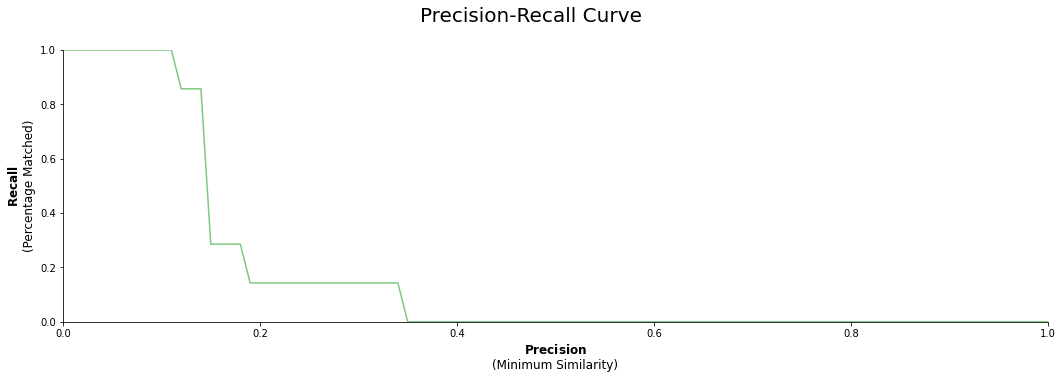

In [111]:
#@title Precision-Recall Curve to visualize the Similarity Scores
model.visualize_precision_recall()

In [81]:
#@title Save the Dataframe
outcome.to_csv('similarity_score.csv', index=False)